# <center>Transfer Learning<br /> Workshop</center>

![logo_ecole_ing.jpg](attachment:logo_ecole_ing.jpg)
Concepteur : Mellila BOUAM
</div>

# Introduction

The aim of this workshop is to introduce you to [transfer learning](https://fr.wikipedia.org/wiki/Apprentissage_par_transfert), a technique used to exploit the knowledge acquired by a model trained on a large dataset on an application task where the amount of available data is limited.

We begin with an intuitive analysis of the effectiveness of transfer learning. We will then prepare the first part, i.e. the data to be used, of the [image annotations](https://fr.wikipedia.org/wiki/Annotation_automatique_d%27images) (image captioning) workshop in which we will train a model using transfer learning.


## What is transfer learning?

Transfer Learning** involves taking features learned on one problem, and using them on another similar problem. For example, the features of a model that has learned to recognize cats can be used to initialize a model that will recognize tigers.

Transfer learning is often performed on tasks where the dataset contains too few examples to train a model from scratch.

The typical workflow for transfer learning in the context of deep learning is as follows:

1. Take layers from a pre-trained model.
2. Freeze the weights of these layers.
3. Add trainable layers (whose weights are not frozen) at the end of the model. These will be used to convert features into predictions on a new dataset.
4. Train the new layers on the new dataset.

- What's the point of freezing the layer weights of the pre-trained model (step 2)?
To protect useful knowledge the model has already learned and avoid ruining it with too little data.


A final optional step, **fine-tuning**, consists in unfreezing all the layers of the model obtained after the previous process and re-training it on the new dataset with a very low learning rate.

- What's the point of the fine-tuning step? Why use a very low learning rate?
Fine-tuning lets the model:

Slightly adjust all layers

Make features more task-specific

Improve performance when the new task is similar to the original one



# Part 1: Intuition on transfer learning
We use InceptionV3 pre-trained on ImageNet as a feature extractor to convert Cats vs Dogs images into embeddings. We then visualize these embeddings in 2D to see whether cats and dogs naturally separate.

In this section, we will load the [InceptionV3](https://paperswithcode.com/method/inception-v3) model pre-trained on a classification task on the [ImageNet](https://image-net.org/) dataset. We will then use this model to compute vector representations (called [embeddings](https://developers.google.
com/machine-learning/crash-course/embeddings/video-lecture?hl=fr)) of images from the [cats vs dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset. We will then represent each embedding on the plane and interpret the results.

## Loading the data
We first load the cats vs. dogs dataset using [TFDS](https://www.tensorflow.org/datasets?hl=fr) (TensorFlow Datasets).

Transfer learning works particularly well on small datasets. Complete the code below to display the number of examples in each dataset.

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [19]:
import tensorflow as tf

DATA_ROOT = r"E:\dev\photonon\cats_dogs_dataset"  # change to your folder

IMG_SIZE = (299, 299)
BATCH_SIZE = 8
SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT + r"\train",
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT + r"\test",
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())
print("Class names:", train_ds.class_names)


Found 23994 files belonging to 2 classes.
Found 8996 files belonging to 2 classes.
Train batches: 3000
Test batches: 1125
Class names: ['Cat', 'Dog']


Let's take a look at the first 9 images in the dataset. Note that class 0 corresponds to "cat" and class 1 to dog.

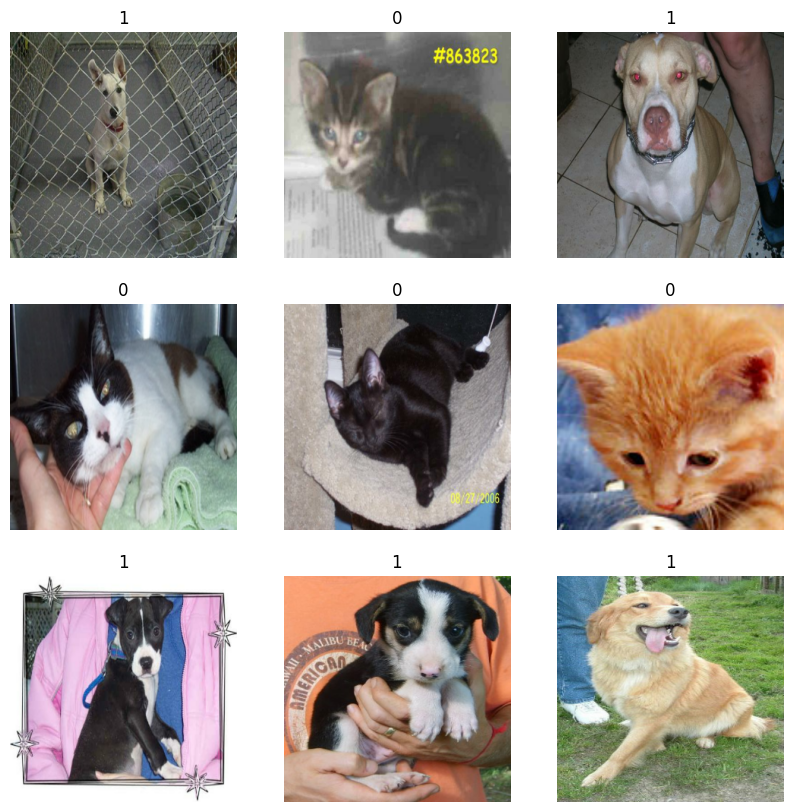

In [20]:
# Displaying a few examples

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(train_ds.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(int(label))
    plt.axis("off")

plt.show()


## Data standardization
The images in the dataset are of different sizes. We therefore need to resize them to match the size expected by the model we're going to use: InceptionV3.

We resize the images to a size of (299x299). To do this, you'll need an image resizing function, which [TensorFLow will provide](https://www.tensorflow.org/api_docs/python/tf/image/resize). Alternatively, if you want to perform the resizing in a single instruction, you can use [lambda expressions](https://www.w3schools.com/python/python_lambda.asp)

In [21]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))


In [22]:

train_ds = train_ds.apply(tf.data.experimental.ignore_errors()).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.apply(tf.data.experimental.ignore_errors()).prefetch(tf.data.AUTOTUNE)


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [23]:
# Downloading the pre-trained InceptionV3 model with cassification from ImageNet

# If we set weights=None -> we'll get embeddings that don't contain any info
# If we set weights='imagenet' -> we'll get semantically relevant embeddings even if the model hasn't been trained on cats vs dogs or cifar10
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet', pooling='avg')

What does the **include_top = false** parameter correspond to?
Removes the final classification layers

Keeps only the feature extractor

Output is not “cat/dog” probabilities

Output is a feature vector (embedding)

What does the **weights='imagenet'** parameter correspond to?
Loads weights learned from ImageNet classification

The model has already learned:

edges

textures

shapes

object parts

Even without training on cats vs dogs, embeddings are meaningful

What does the **pooling='avg'** parameter correspond to?
Applies Global Average Pooling at the end

Converts feature maps into one fixed-size vector

For InceptionV3 → 2048-dimensional embedding
We calculate the embeddings of the images in the test dataset. The dataset contains 2326 images and the size of an embedding is 2048 (see the keras.Model documentation above):


We now define the [model we're going to use](https://www.tensorflow.org/api_docs/python/tf/keras/Model):

In [24]:
inputs = keras.Input(shape=(299, 299, 3))
x = image_model(inputs)
model = keras.Model(inputs=inputs, outputs=x)
model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [25]:
embeddings = model.predict(test_ds.map(lambda x, y: x), verbose=1)
print(embeddings.shape)


1124/1124 ━━━━━━━━━━━━━━━━━━━━ 541s 480ms/step


e:\dev\photonon\transfer_learning\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


(8988, 2048)


In [26]:
# Building the list of true classes of the test dataset examples (1 -> dog, 0 -> cat)

labels = []
for _, y in test_ds:
    labels.extend(
        y.numpy().tolist()
    )
print(len(labels), embeddings.shape[0])

8988 8988


To demonstrate the relevance of using an InceptionV3 model pre-trained on ImageNet, we'll visualize the embeddings of the test dataset and see if there's any separation between the dataset's classes.

In order to visualize the embedding of an image, it must be of dimension 2. However, the embeddings calculated are of size 2048. We will therefore use the [t-SNE] algorithm (https://fr.wikipedia.org/wiki/Algorithme_t-SNE) to reduce the dimension from 2048 to 2.

t-SNE is a dimension reduction algorithm used to visualize high-dimensional data. The algorithm attempts to find a configuration that preserves as much proximity as possible between points when moving from high-dimensional space (here 2048) to low-dimensional space (here 2). We will use the implementation of the library [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [29]:
# We apply the tSNE algorithm to embeddings to reduce their size
# and display them (embeddings size 2048 -> 2)
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)


In [32]:
# Apply t-SNE to reduce embeddings from 2048 -> 2
embeddings_2d = tsne.fit_transform(embeddings)


In [33]:
# We define the color associated with each class (only 2 classes are used in the cats vs dogs case)

colors = {0:'red',
          1:'blue'}



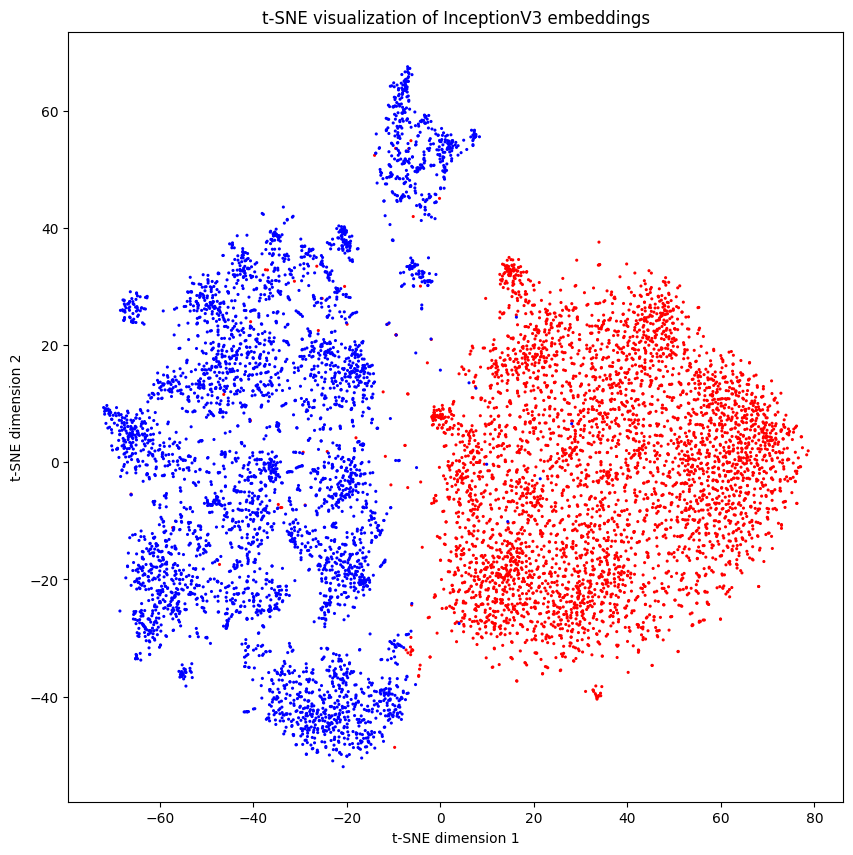

In [34]:
# Plot the image embeddings calculated by InceptionV3
# Each point corresponds to an image and its coordinates are the image's embedding tsne
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    s=1.5,
    c=[colors[l] for l in labels]
)
plt.title("t-SNE visualization of InceptionV3 embeddings")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.show()


What this plot is showing (at a glance)

🔵 Blue points = one class (e.g. dogs)

🔴 Red points = the other class (e.g. cats)

Each dot = one image

Position = where that image lands in the feature space learned by InceptionV3

Axes (“t-SNE dimension 1/2”) have no physical meaning — only distances matter

The most important observation
✅ Clear separation between the two colors

You can see:

A large blue region on the left

A large red region on the right

Very little overlap in the middle

This means:

Images from the same class are represented similarly, and images from different classes are represented differently, even though the model was never trained on cats vs dogs.

That is the core intuition of transfer learning.

Summary: Intuition on Transfer Learning (Up to This Point)

In this part of the work, we explored the intuition behind transfer learning by analyzing how a deep convolutional neural network pre-trained on a large dataset represents images from a new task.

1. Dataset Preparation

We used a local Cats vs Dogs dataset, organized into training and test folders. Images were loaded using TensorFlow utilities, with labels automatically inferred from directory names (0 = cat, 1 = dog).
All images were resized to 299 × 299 pixels, which matches the input size required by the InceptionV3 model.

2. Data Preprocessing

Before feeding images into the model, we applied the InceptionV3-specific preprocessing (preprocess_input). This step normalizes pixel values to the range expected by the model, ensuring compatibility with the representations learned during pre-training on ImageNet.

3. Using InceptionV3 as a Feature Extractor

We loaded the InceptionV3 model pre-trained on ImageNet, removing its final classification layers (include_top=False) and applying global average pooling (pooling='avg').
This configuration turns InceptionV3 into a feature extractor, producing a fixed-size 2048-dimensional embedding for each image.

We then wrapped this network into a Keras model whose output corresponds to image embeddings rather than class predictions.

4. Embedding Extraction

Using the embedding model, we passed all test images through InceptionV3 to compute their embeddings.
Each image was thus represented by a vector of size 2048, capturing high-level visual features such as shapes, textures, and object parts learned from ImageNet.

The resulting embedding matrix had shape:

(number_of_images, 2048)

5. Label Alignment

We constructed a list of true class labels corresponding to the test images and verified that the number of labels exactly matched the number of embeddings.
This ensured that each embedding could be correctly associated with its ground-truth class during visualization.

6. Dimensionality Reduction for Visualization

Since embeddings are high-dimensional and cannot be directly visualized, we applied the t-SNE (t-distributed Stochastic Neighbor Embedding) algorithm to reduce the embeddings from 2048 dimensions to 2 dimensions.
t-SNE preserves local neighborhood structure, making it suitable for visualizing similarities between images.

7. Visualization and Interpretation

We plotted the 2D t-SNE embeddings, coloring each point according to its class (cats vs dogs).
The resulting visualization showed clear clustering by class, with cats and dogs forming mostly separate groups despite the model not being trained on this dataset.

This observation demonstrates that InceptionV3 learns general, transferable visual features, and that these features are already sufficient to separate the two classes in feature space.

Key Takeaway

A model pre-trained on ImageNet (InceptionV3) produces meaningful and discriminative image embeddings for a new task (cats vs dogs) without any additional training, illustrating the core idea and effectiveness of transfer learning.

At this point, Part 1 is complete.
The natural next step would be Part 2, where these embeddings are used to train a classifier by freezing and optionally fine-tuning the model.

# Part 2: Preparing data for transfer learning on an image captioning task

The aim of this part is to prepare the data, through pre-processing, for training a model on the image captioning task. The image captioning task consists in taking an image as input and giving as output a "sentence" describing what this image contains. This last part will be dealt with in the following Workshop.

We will therefore prepare the data for this next workshop, where we will train a model consisting of an InceptionV3 CNN pre-trained on ImageNet to encode images from the COCO dataset into embeddings, followed by an RNN which will be used to decode the embedding and output the textual description of the image. This training represents a typical example of transfer learning.

One slight modification we can make to the transfer learning workflow described earlier is that, instead of freezing the weights of the pre-trained model (InceptionV3), we can pre-calculate the embeddings of the images in the dataset and save them to disk. This will sacrifice some disk space in exchange for runtime (no need to calculate image embeddings at each epoch) and GPU memory (no need to load the InceptionV3 model during training).

With this modification, on the other hand, it will no longer be possible to perform the fine-tuning phase, which consists of PLEASE COMPLETE the training of the InceptionV3 model with a very slight adjustment of the weights (very low learning rate) to optimize the embeddings it builds.

# 1 Downloading data :
First, we need to import the libraries we'll need for this part.

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

You need to download the [MS COCO] dataset (https://cocodataset.org/#home). This dataset contains 82,000 annotated images, each with 5 captions. Download the [dataset](http://images.cocodataset.org/zips/train2014.zip), the [corresponding annotations](http://images.cocodataset.org/annotations/annotations_trainval2014.zip), and unzip them into the correct directory. The code below displays the path to the folder containing the data and the annotation file (`annotation_file` and `PATH`).

In [ ]:
# Annotation file path
annotation_folder = os.path.abspath('.')+"/annotations/"
annotation_file = annotation_folder+"captions_train2014.json"

# Path to folder containing images to be annotated
image_folder = '/train2014/'
PATH = os.path.abspath('.') + image_folder

print("annotation file ", annotation_file)
print("PATH path ", PATH)

In [ ]:
with open(annotation_folder+"/captions_val2014.json", 'r') as f:
    annotations = json.load(f)

In [ ]:
with open(annotation_folder+"instances_val2014.json", 'r') as f:
    instances = json.load(f)

We want to select a subset of images to make learning faster. The aim is to take only 35,000 images instead of the 82,000 in the original dataset. To do this, we can create a structure that associates each image with its list of annotations. How could we represent this intermediate data?
<em>PLEASE COMPLETE</em>

In [ ]:
# Read annotation file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Group all annotations with the same identifier.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # mark the beginning and end of each annotation
    caption = #PLEASE COMPLETE
    # Image ID is part of the image path
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Add caption associated with image_path
    #PLEASE COMPLETE

In [ ]:
# Take first images only
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:2000]
print(len(train_image_paths))

Now it's time to build the dataset itself. The code producing this dataset is composed of :
<ul>
        <li>The `img_name_vector` list, which contains the names of the image files associated with the annotations. These are the examples in the dataset. </li>
        <li>The `train_captions` list containing the annotations. This is the labels.</li>
</ul>
You can display an example for verification.

In [ ]:
# List of all annotations
train_captions = []
# List of all duplicated image file names (in number of annotations per image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Add caption_list to train_captions
    #PLEASE COMPLETE
    # Add duplicate image_path len(caption_list) times
    #PLEASE COMPLETE

In [ ]:
print(len(train_captions), len(img_name_vector))
print(train_captions[0])
Image.open(img_name_vector[0])

# 2 Image pre-processing
What we're going to do next is load the neural network that will handle the vision part of the annotation problem. In fact, the overall architecture of the system will contain two parts:
<ul>
    <li>A CNN whose role will be to summarize and extract the raw and voluminous content of the information carried by the pixels into a compact representation that brings together the essential features to perform the annotation.</li>
    <li>And an RNN which will have as input this compact representation and whose goal is to learn the next word from the first words of the annotation.</li>
</ul>

To create a new model you can use the `tf.keras.Model` function in [tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/Model). For the CNN part, you won't have to design your own architecture for the neural network, you'll have to use an architecture that already exists and is called [InceptionV3](https://paperswithcode.com/method/inception-v3). You can download the weights of this architecture obtained by pre-training on the [ImageNet](http://www.image-net.org/) dataset (used in classification). This network will therefore be trained to perform image classification, but you will use the last hidden layer of this network (i.e. the penultimate layer, as the last layer corresponds to the ImageNet classes), to later provide input to your RNN. The RNN, as we said earlier, will have to learn to perform annotation based on these image representations.

Since training is generally performed by making several passes over the data, the advantage of precomputing image representations is that you don't have to run the images through the CNN each time, and you avoid the training costs associated with the CNN. The potential disadvantage is that performance is likely to be more limited, as training will only involve the weights of the RNN and not those of the CNN.

In [ ]:
# Download the pre-trained InceptionV3 model with cassification from ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation of a variable that will be the input to the new image pre-processing model
new_input = #PLEASE COMPLETE
# retrieve the last hidden layer containing the image in compact representation
hidden_layer = #PLEASE COMPLETE

# Model that calculates a dense representation of images with InceptionV3
image_features_extract_model = #PLEASE COMPLETE

In [ ]:
def load_image(image_path):
    """
    The load_image function has as input the path of an image and as output a pair
    containing the processed image and its path.
    The load_image function performs the following processing:
        1. Loads the file corresponding to the path image_path
        2. Decodes the image into RGB.
        3. Resize image to size (299, 299).
        4. Normalize image pixels between -1 and 1.
    """
    img = #PLEASE COMPLETE
    img = #PLEASE COMPLETE
    img = #PLEASE COMPLETE
    img = #PLEASE COMPLETE
    return img, image_path

Since you already have a pre-trained CNN, it's best to carry out the training on the representations returned by the CNN, as they are more compact and therefore less costly in terms of memory and time. If your RAM isn't big enough, you'll need to cache them on disk. The last layer of the CNN has the shape `8x8x2048`. You will then store these images as `numpy.array` on disk using the `np.save()` function.

**Note:** Processing in TensorFlow is done by batch (which is easier on the GPU), so you'll need to configure your batch to pass your images to InceptionV3.

In [ ]:
from tqdm import tqdm

# Pre-process images
# Take image names
encode_train = sorted(set(img_name_vector))

# Create an instance of "tf.data.Dataset" based on image names
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Data split into batches after pre-processing by load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Browse dataset batch by batch for InceptionV3 pre-processing
for img, path in tqdm(image_dataset):
    # InceptionV3 pre-processes the current batch (size (16,8,8,2048))
    batch_features = #PLEASE COMPLETE
    # Resize batch size (16,8,8,2048) to (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Browse current batch and store path and batch with np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (image path associated with its new representation , image representation)
        np.save(
            #PLEASE COMPLETE
        )

# 3 Pre-processing annotations

To make annotations we need to be able to process the text automatically by following the steps below:
<ul>
    <li>Build a vocabulary of the words contained in the captions. To do this we need to tokenize (divide) the words in the captions on special characters (spaces, punctuation, special signs, ...).</li>
    <li>This vocabulary will be far too voluminous; we'll have to limit ourselves, for example, to the first 5000 most frequent words. You can replace other words with a special token named "UNK" (unknown).</li>
    <li>The words must also be numbered in the dictionary to form annotations represented in a way that is legible for word processing algorithms.</li>
    <li>The examples (annotations) will be filled in so that they all have the same size (the maximum size of the annotations).</li>
</ul>

In [ ]:
# Find the maximum size
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Select the 5000 most frequent words in the vocabulary
top_k = 5000
#The Tokenizer class enables text pre-processing for neural networks
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Builds a vocabulary based on the train_captions list
tokenizer.fit_on_texts( #PLEASE COMPLETE

# Create token to fill annotations to equalize length
tokenizer.word_index['<pad>'] = #PLEASE COMPLETE
tokenizer.index_word[0] = #PLEASE COMPLETE

# Creation of vectors (list of integer tokens) from annotations (list of words)
train_seqs = #PLEASE COMPLETE

# Fill each vector up to maximum annotation length
cap_vector = #PLEASE COMPLETE

# Calculates the maximum length used to store attention weights
# It will later be used for display during evaluation
max_length = calc_max_length(train_seqs)

Later (in the next workshop), we'll take up this second part and move on to the training and testing set, the construction of the model we're going to train, and the training and testing phase.